In [1]:
library(infer)
library(repr)
library(readr)
library(tidyverse)
library(RColorBrewer)

library(cowplot)
library(datateachr)
library(digest)
library(taxyvr)
library(broom)
library(testthat)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ dplyr   1.0.10
✔ tibble  3.1.8      ✔ stringr 1.4.1 
✔ tidyr   1.2.1      ✔ forcats 0.5.2 
✔ purrr   0.3.4      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


The following objects are masked from ‘package:readr’:

    edition_get, local_edition




In [2]:
raw_data <- read_csv('https://github.com/AVietCong/stat201-group22-project/raw/main/Gender_Pay_Gap_dataset.csv')
head(raw_data)

Rows: 53790 Columns: 129
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): adj_occ2name
dbl (127): year, serial, numprec, gq, region, statefip, metro, metarea, coun...
lgl   (1): farm

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


year,serial,numprec,gq,region,statefip,metro,metarea,county,farm,⋯,foodcare,building,sales,officeadmin,farmer,constructextractinstall,production,transport,sumadj_occ,LEHS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2013,4484,1,1,11,50,1,NA,NA,NA,⋯,0,0,0,0,0,0,0,0,1,1
2013,21761,3,1,21,39,3,2002,NA,NA,⋯,0,0,0,0,0,1,0,0,1,1
2013,7174,4,1,11,44,2,6483,NA,NA,⋯,0,0,0,0,0,0,0,0,1,1
2013,58428,1,1,31,12,3,4901,12009,NA,⋯,0,0,0,0,0,0,0,0,1,1
2013,2894,3,1,11,33,1,NA,NA,NA,⋯,0,0,0,0,0,0,0,1,1,1
2013,56021,1,1,31,12,4,2900,12001,NA,⋯,0,0,0,0,0,1,0,0,1,1


In [3]:
raw_data$industry <- colnames(raw_data[,89:127])[apply(raw_data[,89:127], 1, which.max)]
head(raw_data)

year,serial,numprec,gq,region,statefip,metro,metarea,county,farm,⋯,building,sales,officeadmin,farmer,constructextractinstall,production,transport,sumadj_occ,LEHS,industry
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2013,4484,1,1,11,50,1,NA,NA,NA,⋯,0,0,0,0,0,0,0,1,1,Medical
2013,21761,3,1,21,39,3,2002,NA,NA,⋯,0,0,0,0,1,0,0,1,1,publicadmin
2013,7174,4,1,11,44,2,6483,NA,NA,⋯,0,0,0,0,0,0,0,1,1,professional
2013,58428,1,1,31,12,3,4901,12009,NA,⋯,0,0,0,0,0,0,0,1,1,finance
2013,2894,3,1,11,33,1,NA,NA,NA,⋯,0,0,0,0,0,0,1,1,1,miningconstruction
2013,56021,1,1,31,12,4,2900,12001,NA,⋯,0,0,0,0,1,0,0,1,1,miningconstruction


In [8]:
filtered_data <- select(raw_data, sex, race, hrwage, incwage, sch, wkswork1, uhrswork, potexp, industry) %>%
    mutate(sex = as.factor(sex),
           race = as.factor(race),
           hrwage = as.double(hrwage),
           incwage = as.double(incwage),
           sch = as.double(sch),
           wkswork = as.integer(wkswork1),
           uhrswork = as.integer(uhrswork),
           potexp = as.integer(potexp),
            industry = as.character(industry))
head(filtered_data)

sex,race,hrwage,incwage,sch,wkswork1,uhrswork,potexp,industry,wkswork
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<int>
1,1,24.91259,57000,14,52,44,42,Medical,52
1,1,31.00000,62000,13,50,40,40,publicadmin,50
1,3,21.63461,45000,12,52,40,26,professional,52
1,1,12.82051,28000,12,52,42,23,finance,52
1,1,21.25000,42500,12,50,40,17,miningconstruction,50
1,1,21.87500,35000,11,40,40,18,miningconstruction,40


In [9]:
pay_data <- filtered_data %>%
    mutate(sex = fct_recode(sex, 'male' = '1', 'female' = '2'),
           race = fct_recode(race, 'White' = '1', 'Black' = '2', 'Hispanic' = '3', 'Other' = '4'),
           education_level = case_when(sch == 0 ~ 'None',
                                       sch < 12 ~ 'Incomplete Schooling', 
                                       sch == 12 ~ 'Highschool',
                                       sch == 13 ~ 'College',
                                       sch == 14 ~ 'Associate Degree',
                                       sch <= 16 ~ 'BA',
                                       sch <= 18 ~ 'Advanced Degree'))
head(pay_data)

sex,race,hrwage,incwage,sch,wkswork1,uhrswork,potexp,industry,wkswork,education_level
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<int>,<chr>
male,White,24.91259,57000,14,52,44,42,Medical,52,Associate Degree
male,White,31.00000,62000,13,50,40,40,publicadmin,50,College
male,Hispanic,21.63461,45000,12,52,40,26,professional,52,Highschool
male,White,12.82051,28000,12,52,42,23,finance,52,Highschool
male,White,21.25000,42500,12,50,40,17,miningconstruction,50,Highschool
male,White,21.87500,35000,11,40,40,18,miningconstruction,40,Incomplete Schooling


In [10]:
print("Count of missing values by column wise")
sapply(pay_data, function(x) sum(is.na(x)))

[1] "Count of missing values by column wise"


sex            race          hrwage         incwage             sch 
              0               0               0               0               0 
       wkswork1        uhrswork          potexp        industry         wkswork 
              0               0               0               0               0 
education_level 
              0

In [11]:
for (x in list("male", "female")) {
    cat("mean for " , x , ": ", mean(subset(pay_data, sex==x)$hrwage), "\n")
    cat("median for ",x,": ", median(subset(pay_data, sex==x)$hrwage), "\n")
    cat("sd for ",x,": ", sd(subset(pay_data, sex==x)$hrwage), "\n", "\n")
}

mean for  male :  28.84364 
median for  male :  21.63461 
sd for  male :  221.4018 
 
mean for  female :  21.92408 
median for  female :  17.30769 
sd for  female :  23.50221 
 


In [12]:
sex_summary <- pay_data |>
    group_by(sex) |>
    summarise(count = n())
sex_summary

sex,count
<fct>,<int>
male,27225
female,26565


In [13]:
data <- pay_data[, c("sex", "hrwage")]
head(data)

sex,hrwage
<fct>,<dbl>
male,24.91259
male,31.00000
male,21.63461
male,12.82051
male,21.25000
male,21.87500


In [14]:
test <- t.test(hrwage ~ sex, data = data)
test


	Welch Two Sample t-test

data:  hrwage by sex
t = 5.1273, df = 27853, p-value = 2.959e-07
alternative hypothesis: true difference in means between group male and group female is not equal to 0
95 percent confidence interval:
 4.274369 9.564756
sample estimates:
  mean in group male mean in group female 
            28.84364             21.92408 


In [15]:
set.seed(2345)
sample <- 
    data %>%
    group_by(sex) %>%
    sample_n(size = case_when(sex == "male" ~ 200,
                              sex == "female" ~ 200), replace = FALSE) %>%
    ungroup()
head(sample)

sex,hrwage
<fct>,<dbl>
male,24.55621
male,44.23077
male,19.23077
male,96.15385
male,72.11539
male,19.11765


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



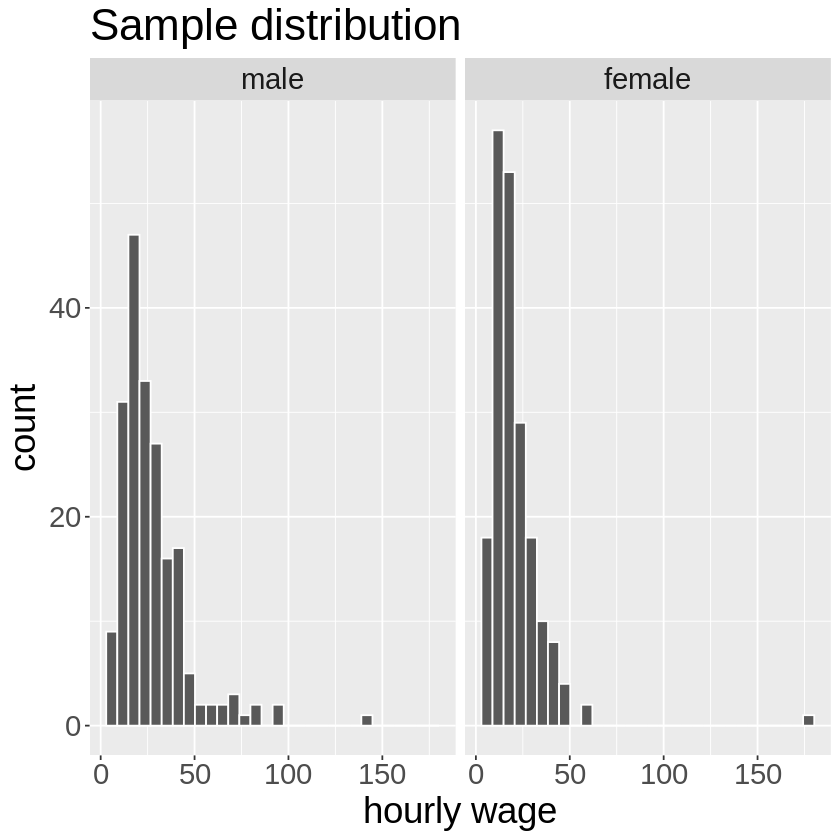

In [ ]:
samp_dist_plot <- 
    sample %>% 
    ggplot() + 
    geom_histogram(aes(hrwage), color = 'white') +
    facet_wrap(~ sex) + 
    theme(text = element_text(size = 22)) +
    ggtitle("Sample distribution") + 
    xlab("hourly wage")

samp_dist_plot

In [20]:
sample_summary <- 
    sample %>%
    group_by(sex) %>%
    summarise(sample_med = median(hrwage),
             sample_std_error = sd(hrwage)/sqrt(n()))
sample_summary

sex,sample_med,sample_std_error
<fct>,<dbl>,<dbl>
male,23.07692,1.274007
female,17.54856,1.069211


In [21]:
ci = 0.95

male_med <- sample_summary$sample_med[1]
male_var <- sample_summary$sample_std_error[1]^2
female_med <- sample_summary$sample_med[2]
female_var <- sample_summary$sample_std_error[2]^2

parking_clt_ci <- 
    tibble(lower_ci = (male_med - female_med - qnorm(1- (1-ci)/2) * sqrt(female_var + male_var)),
           upper_ci = (male_med - female_med + qnorm(1- (1-ci)/2) * sqrt(female_var + male_var)))

head(parking_clt_ci)

lower_ci,upper_ci
<dbl>,<dbl>
2.268512,8.78822


In [24]:
t_test_summary <- sample %>%
    group_by(sex) %>%
    summarise(
        n = n(),
        x_bar = median(hrwage),
        sd = sd(hrwage)
    ) %>% 
  pivot_wider(names_from = sex, values_from = c(n, x_bar, sd)) %>% 
  mutate(
    median_diff = x_bar_male - x_bar_female
  )

t_test_summary <- t_test_summary %>%
mutate(null_std_error = sqrt((sd_male^2 / n_male) + (sd_female^2 / n_female)))

t_test_summary <- 
    t_test_summary %>% 
    mutate(p_value = 2 * pt(median_diff/null_std_error, df=n_male+n_female-1, lower.tail=FALSE))

t_test_summary

n_male,n_female,x_bar_male,x_bar_female,sd_male,sd_female,median_diff,null_std_error,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200,200,23.07692,17.54856,18.01718,15.12093,5.528366,1.663222,0.0009697577


In [25]:
t_test <- 
    tidy(t.test(sample %>% filter(sex == "male") %>% pull(hrwage),
           sample %>% filter(sex == "female") %>% pull(hrwage)))

t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
7.065363,27.38946,20.3241,4.247999,2.70583e-05,386.3729,3.795265,10.33546,Welch Two Sample t-test,two.sided
